In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

import pickle

In [2]:
data_path = "data.csv"
df = pd.read_csv(data_path)
df.head()

,age,program_name,days_of_exercise_per_week
0,20,body workout,5
1,21,body workout,4
2,22,Recipes,5
3,23,body workout,4
4,24,body workout,6


### Remove labels of program_name from the dataset

In [3]:
X = df[['age', 'days_of_exercise_per_week']]
y = df['program_name']

In [4]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
X = pd.DataFrame(scaled_data, columns=X.columns)
X.head()

,age,days_of_exercise_per_week
0,-1.628731,1.606410
1,-1.519421,1.076825
2,-1.410110,1.606410
3,-1.300799,1.076825
4,-1.191488,2.135996


In [5]:
# Save the scaler using pickle for future use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### Below we use the Elbow Method to Find the Optimal Number of Clusters


Calculating inertia for k=1 to 10...


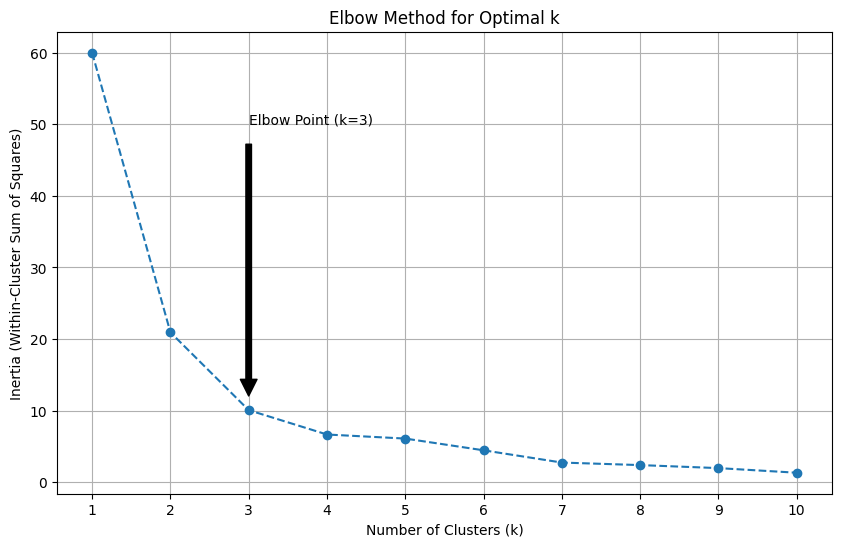

In [6]:
# We will test a range of k values from 1 to 10
k_range = range(1, 11)
inertia_values = []

print("\nCalculating inertia for k=1 to 10...")

for k in k_range:
    # Initialize and fit the KMeans model for the current k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    
    # Append the inertia (WCSS) to our list
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)
# Annotate the elbow point
plt.annotate('Elbow Point (k=3)', xy=(3, inertia_values[2]), xytext=(3, 50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

### Below we use hierarchical clustering and dendrogram. 
To double check elbow method's suggested K number

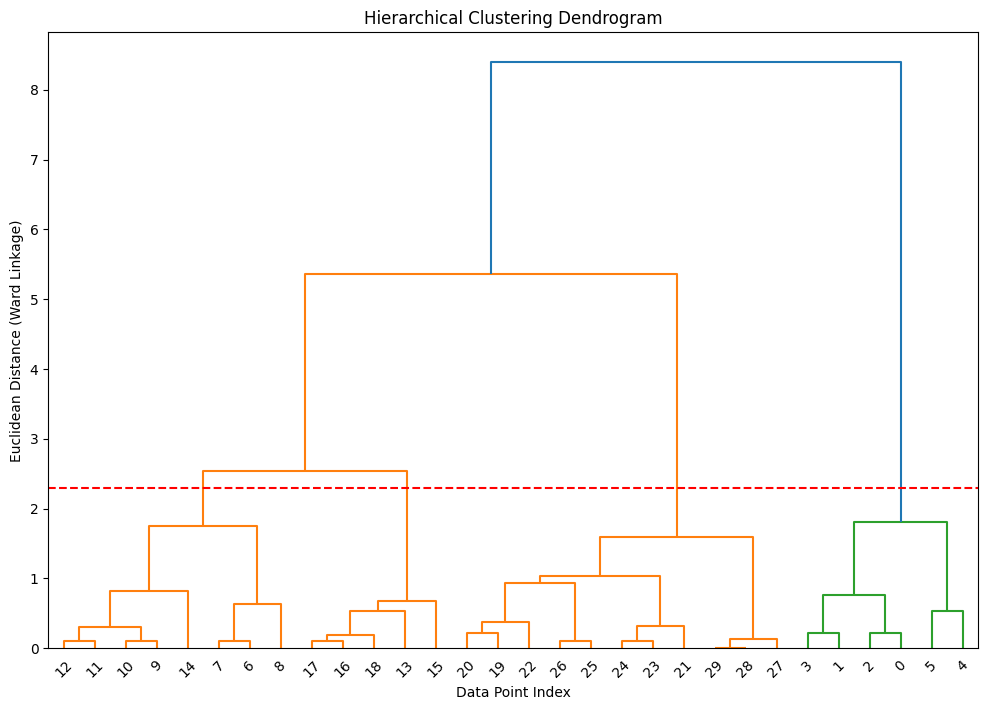

In [7]:
# The 'linkage' function from SciPy calculates the distances between clusters.
# 'ward' is a common linkage method that minimizes the variance of the clusters being merged.
linked = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked,
           orientation='top',
           labels=X.index, # Optional: label the x-axis with data point indices
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point Index')
plt.ylabel('Euclidean Distance (Ward Linkage)')

# Add a horizontal line to suggest the optimal cut
# We find the largest gap and draw a line through it.
# In this case, the largest gap is between 2 and 3 on the y-axis.
plt.axhline(y=2.3, color='r', linestyle='--') 
plt.annotate('Cut here (k=3)', xy=(60, 15), xytext=(70, 25),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# As we see the number of clusters do match Between the Dendrogram and elbow methods
### Thus we will use K=3

# Perform K-Means Clustering with k = 3


In [8]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X)

# Add the predicted cluster labels back to our original DataFrame to see the results
X['cluster'] = cluster_labels

X.head()

,age,days_of_exercise_per_week,cluster
0,-1.628731,1.606410,2
1,-1.519421,1.076825,2
2,-1.410110,1.606410,2
3,-1.300799,1.076825,2
4,-1.191488,2.135996,2


In [9]:
# Get the coordinates of the cluster centers (centroids)
centroids = kmeans.cluster_centers_
centroids

array([[-0.5356231 ,  0.07649574],
       [ 0.86355561, -0.72376737],
       [-1.35545437,  1.69467481]])

In [10]:
# Save the kmeans using pickle for future use
with open('kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Create a scatter plot

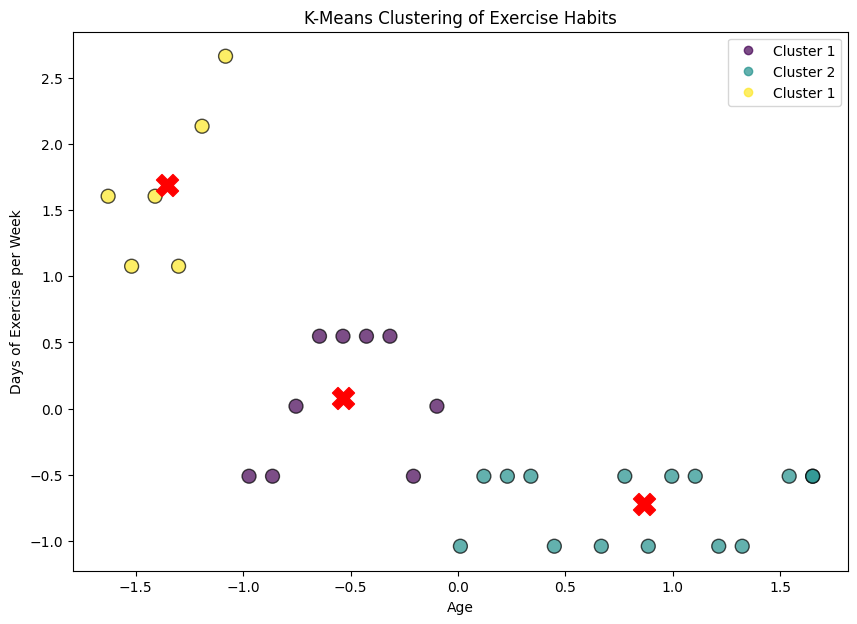

In [11]:
plt.figure(figsize=(10, 7))

# Plot the data points, coloring them by their assigned cluster label
scatter = plt.scatter(
    X['age'], 
    X['days_of_exercise_per_week'], 
    c=X['cluster'],         # Color points by their cluster
    cmap='viridis',          # Use a nice color map
    s=100,                   # Set marker size
    alpha=0.7,               # Set transparency
    edgecolor='k'            # Add black edge to markers
)

# Plot the centroids on top, marking them with a red 'X'
plt.scatter(
    centroids[:, 0],         # Centroid x-coordinate (Age)
    centroids[:, 1],         # Centroid y-coordinate (days of exercise)
    c='red',
    marker='X',
    s=250,                   # Make the centroid marker larger
    label='Centroids'
)

# Add titles and labels for clarity
plt.title('K-Means Clustering of Exercise Habits')
plt.xlabel('Age')
plt.ylabel('Days of Exercise per Week')
plt.legend(handles=scatter.legend_elements()[0], labels=['Cluster 1', 'Cluster 2', 'Cluster 1'])
# plt.grid(True)
plt.show()

# After clustering the users, each cluster prefered products

In [12]:
X['products'] = y
X.head()

,age,days_of_exercise_per_week,cluster,products
0,-1.628731,1.606410,2,body workout
1,-1.519421,1.076825,2,body workout
2,-1.410110,1.606410,2,Recipes
3,-1.300799,1.076825,2,body workout
4,-1.191488,2.135996,2,body workout


In [13]:
percentages_table = X.groupby('cluster')['products'].value_counts(normalize=True).mul(100).rename('percentage')
percentages_table

cluster  products    
0        productivity    100.000000
1        Recipes          80.000000
         body workout     20.000000
2        body workout     83.333333
         Recipes          16.666667
Name: percentage, dtype: float64

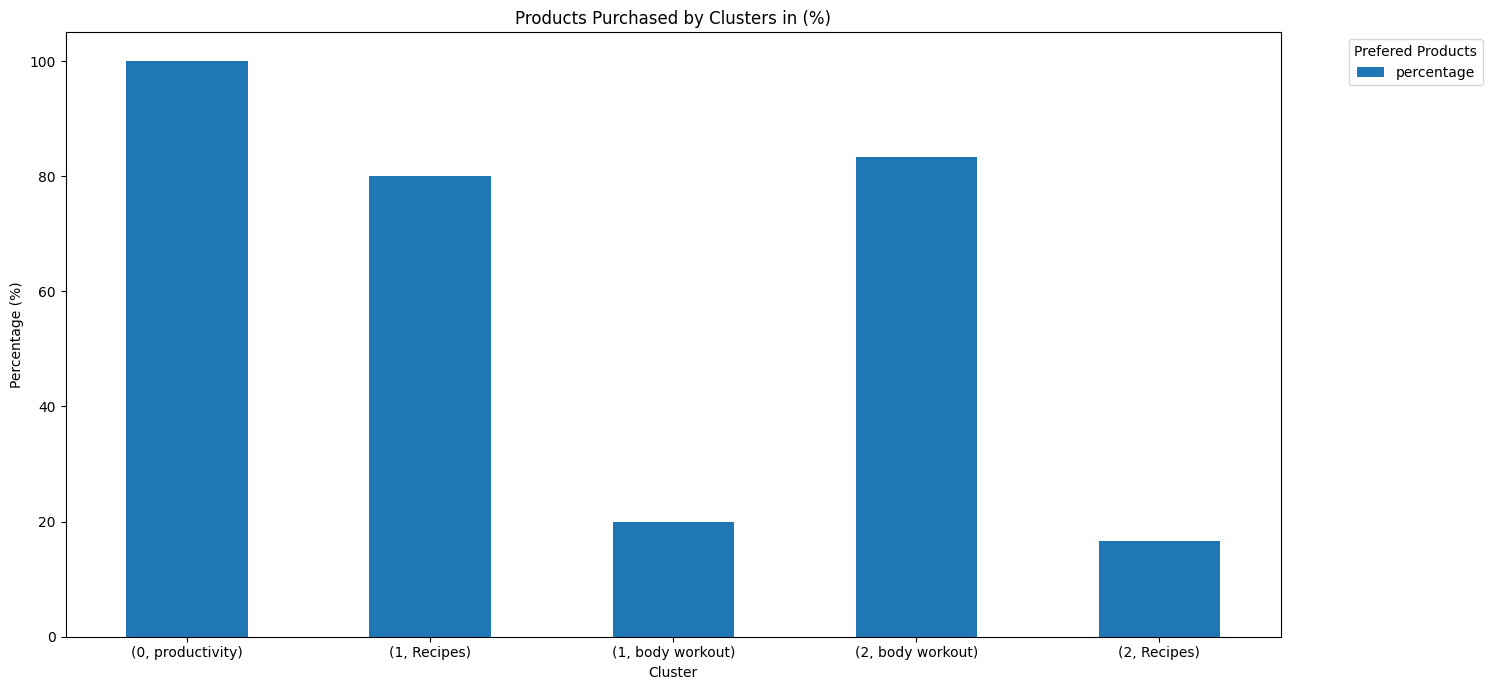

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(15, 7))
percentages_table.plot(kind='bar', ax=ax)

# Make it pretty
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Cluster')
ax.set_title('Products Purchased by Clusters in (%)')
ax.legend(title='Prefered Products', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# As we see from the plots, per each cluster ID we have huge tendency to prefer a specific product 

Ignore below code

In [24]:

index_to_product = dict(zip(X['cluster'], X['products']))
index_to_product

{2: 'body workout', 0: 'productivity', 1: 'body workout'}